# Time Evolution with Noise

Now we introduce classical noise to the system. We model the Hamiltonian as:
$$
    \newcommand{ket}[1]{\left|#1\right\rangle}
    \newcommand{bra}[1]{\left\langle#1\right|}
    H(t) = H_\textrm{ff} + \sum_i f_i(t)h_i
$$
For our system in particular, we model the noise as fluctuations in the applied electric field.
$$
    h_i = \frac{1}{2}\omega_iZ_i
$$
With this in mind, the time evolution of the density matrix is now given by:
$$
\vec{\rho}(t) = \sum_{jk}e^{-i\omega_{jk}t}(R\otimes R)(\ket{j}\bra{j}\otimes\ket{k}\bra{k})e^{-\sum_iK_i(t)}(R^{-1}\otimes R^{-1})\vec{\rho}(0)
$$
with $K_i(t)$ giving us the decoherence due to the noise and is given by:
$$
K_i(t) =\sum_{abc}(h_{i,ab}h_{i,bc}J_i(t,\omega_{ba},\omega_{cb})\ket{a}\bra{c}\otimes 1+h_{i,ba}h_{i,cb}J_i(t,\omega_{ab},\omega_{bc}) 1\otimes \ket{a}\bra{c})-\sum_{abcd}h_{i,ac}h_{i,db} (J_i(t,\omega_{ca},\omega_{db})+J_i(t,\omega_{db},\omega_{ca})) \ket{a}\bra{c}\otimes \ket{b}\bra{d}
$$
If we consider only dephasing and neglect all other terms, $K$ can be simplified to
$$
    K_i(t) = J_i(t,0,0)\sum_{jk}\Gamma_{ijk}^2(\ket{j}\bra{j}\otimes\ket{k}\bra{k})
$$
where $\hbar\Gamma_{ijk} = \bra{j}R^{-1}h_iR\ket{j}-\bra{k}R^{-1}h_iR\ket{k}$ is the decoherence rate for that particular matrix element. The density matrix is then simply:
$$
\vec{\rho}(t) = \sum_{jk}e^{-i\omega_{jk}t - \sum_i J_i(t,0,0)\Gamma_{ijk}^2}(R\otimes R)(\ket{j}\bra{j}\otimes\ket{k}\bra{k})(R^{-1}\otimes R^{-1})\vec{\rho}(0)
$$
with $R$ the eigenvector matrix and $\omega_{jk}$ the eigenvalues of the system.


## Flip Flop Qubit
Again, the Hamiltonian for the flip-flop qubit is:
$$
H_\textrm{ff} = \hbar \sum_m \omega_c^{(m)} a_m^\dagger a_m + \sum_i\sum_j E_{ij} \ket{j}_i\bra{j}_i + \sum_m\sum_i\frac{1}{2}g_c^{(m)}(a_m+a_m^\dagger)(1+Z_i)
$$
with the $m$ are all cavity modes (we'll be considering only a simgle mode for now so we can ignore the summation over $m$), $i$ are each flip-flop qubit, and $j$ are the states of each qubit.

$Z$ is the electron position and is defined as: 
$$
Z = \sum_{jk} z_{jk}\sigma_j\tau_j 
$$
$\omega_c$ is the cavity energy and $g_c$ is the photon-charge coupling strength. The eigenenergies up to second order in perturbation theory in the single qubit case are:
$$
        \begin{align}
            E_0 &= \frac{1}{2}(-\omega_0-\omega_B)-\frac{A}{8} \left(1-\cos \eta\right)-\frac{\Delta\omega_B}{4}\left(1+\cos \eta\right)-\frac{A^2}{16\omega_B}\left((1-\cos\eta)^2+\sin^2\eta(\frac{\omega_B}{4\omega_0}+\frac{\omega_B}{\omega_0+\omega_B}-\frac{\omega_B\Delta\omega_B}{A\omega_0}+\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right)\\
            E_1 &= \frac{1}{2}(-\omega_0+\omega_B)-\frac{A}{8} \left(1-\cos \eta\right)+\frac{\Delta\omega_B}{4}\left(1+\cos \eta\right)-\frac{A^2}{16\omega_B}\left(-(1-\cos\eta)^2+\sin^2\eta(\frac{\omega_B}{4\omega_0}+\frac{\omega_B}{\omega_0-\omega_B}+\frac{\omega_B\Delta\omega_B}{A\omega_0}+\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right) \\
            E_2 &= \frac{1}{2}( \omega_0-\omega_B)-\frac{A}{8} \left(1+\cos \eta\right)-\frac{\Delta\omega_B}{4}\left(1-\cos \eta\right)-\frac{A^2}{16\omega_B}\left((1+\cos\eta)^2+\sin^2\eta(-\frac{\omega_B}{4\omega_0}-\frac{\omega_B}{\omega_0-\omega_B}+\frac{\omega_B\Delta\omega_B}{A\omega_0}-\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right) \\
            E_3 &= \frac{1}{2}( \omega_0+\omega_B)-\frac{A}{8} \left(1+\cos \eta\right)+\frac{\Delta\omega_B}{4}\left(1-\cos \eta\right)-\frac{A^2}{16\omega_B}\left(-(1+\cos\eta)^2+\sin^2\eta(-\frac{\omega_B}{4\omega_0}-\frac{\omega_B}{\omega_0+\omega_B}-\frac{\omega_B\Delta\omega_B}{A\omega_0}-\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right)
        \end{align}
$$
and the coefficients of $Z$ are
$$
        \begin{align}
            z_{01} &= -A\omega_0\Delta\omega_B\cos\eta\sin^2\eta/4\omega_B(\omega_0^2-\omega_B^2) \\
            z_{03} &= A^2\omega_0^3\cos\eta\sin^2\eta/4\omega_B(\omega_0^2-\omega_B^2)^2 \\
            z_{10} &= \sin\eta + A\cos\eta\sin\eta/4\omega_0 \\
            z_{11} &= -A\omega_0\cos\eta\sin\eta/2(\omega_0^2-\omega_B^2) \\
            z_{13} &= -\Delta\omega_B\cos\eta\sin\eta/2\omega_0 \\
            z_{22} &= -A\omega_0^2\cos\eta\sin\eta/2\omega_B(\omega_0^2-\omega_B^2) \\
            z_{30} &= \cos\eta - A\sin^2\eta/4\omega_0 \\
            z_{31} &= A\omega_0\sin^2\eta/2(\omega_0^2-\omega_B^2) \\
            z_{33} &= \Delta\omega_B\sin^2\eta/2\omega_0 
        \end{align}
$$

We also don't care so much about the photon number so we should trace out that degree of freedom.
$$
    \rho_{\textrm{ff}}(t) = \textrm{Tr}_c(\rho(t))
$$

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import System functions and Hamiltonians
from Scripts.DensityMatrix_TimeEvolution import *
from Scripts.plotTimeEvolution import *
from Scripts.Noise.Pink import *
from Scripts.Systems.FlipFlop import *
from Scripts.Systems.FlipFlopSW import *

Energies: [[-11.31108994   0.           0.           0.        ]
 [  0.          -0.17319912   0.           0.        ]
 [  0.           0.           0.14282806   0.        ]
 [  0.           0.           0.          11.28296099]]
Zcoefs: [[ 0.00000000e+00  9.56268567e-06  0.00000000e+00  9.46947558e-04]
 [ 9.95205331e-01 -9.61713913e-03  0.00000000e+00  9.71180270e-05]
 [ 0.00000000e+00  0.00000000e+00 -9.88267357e-03  0.00000000e+00]
 [ 9.78406870e-02  9.53351183e-02  0.00000000e+00 -9.62735224e-04]]

 gf =  4.76675591669666e-05
 gc =  0.0004976026656074048
 df =  0.0
 dc =  0.3160271809390576
 z11 =  -0.009617139130177463
 z22 =  -0.009882673573527099
 wn =  0.323
0.0
25000.0
50000.0
75000.0
100000.0
125000.0
150000.0
175000.0
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


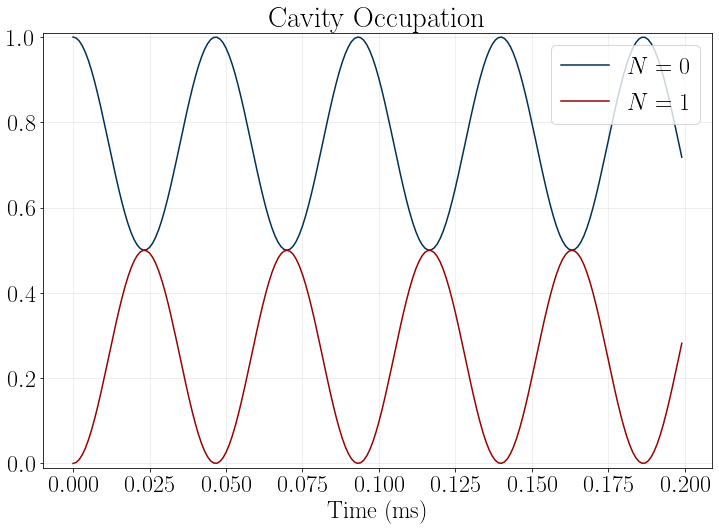

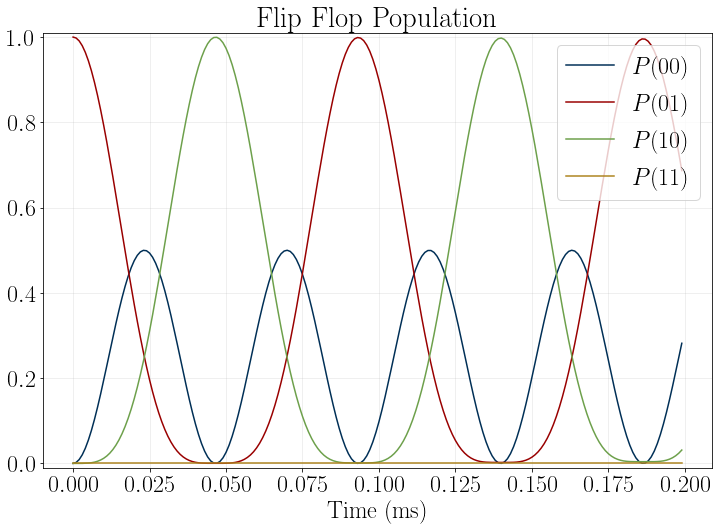

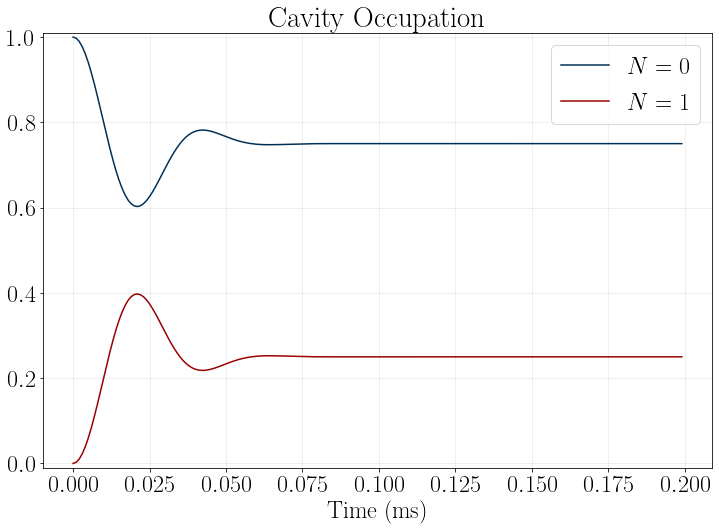

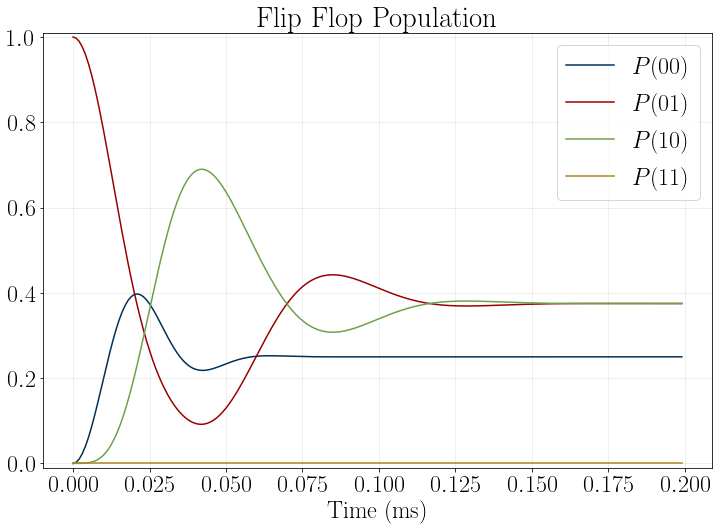

In [2]:
Nq = 4 # Number of states per qubit
Nm = 1 # Number of cavity modes

# You can play around with these
Nd = 2 # Number of donor qubits
Np = 1 # Maximum number of photons per mode
Nn = 2 # Nd

#                    IX, IZ, XI, XX, XZ, YY, ZI, ZX, ZZ
approxInteraction = [ 0,  0,  1,  0,  0,  0,  0,  1,  0]
approxNoise =       [ 0,  0,  0,  1,  0,  1,  0,  0,  0]

# Initialize cavity( to va)cuum state
initial_cavity_state_single_mode = np.zeros(((Np+1),1))
initial_cavity_state_single_mode[1,:] = 1
initial_cavity_state_multi_modes = [initial_cavity_state_single_mode] * Nm
initial_cavity_state = kron(initial_cavity_state_multi_modes)

# Initialize flip-flop to be |0...0>|1>
initial_flipflop_state = np.zeros(((4)**Nd,1))
initial_flipflop_state[1,:] = 1

initial_total_state = np.kron(initial_cavity_state,initial_flipflop_state)

# wcs=[0,0.001,-0.001, 0.01, -0.01]
# gcs=[0.1,0.01,0.001]
noisenum=[0,2]

simParam = [
    # {'wc':0, 'g':0.01, 'Tmax':50000},
    {'wc':0, 'g':0.001, 'Tmax':200000},
    # {'wc':-0.01, 'g':0.01, 'Tmax':250000},
    # {'wc':-0.01, 'g':0.001, 'Tmax':2000000},
    # {'wc':-1, 'g':0.01, 'Tmax':200000},
]
for initialPhoton in [0]:#range(Np+1):
    for initialFF in [1]:
        # Initialize cavity( to va)cuum state
        initial_cavity_state_single_mode = np.zeros(((Np+1),1))
        initial_cavity_state_single_mode[initialPhoton,:] = 1
        initial_cavity_state_multi_modes = [initial_cavity_state_single_mode] * Nm
        initial_cavity_state = kron(initial_cavity_state_multi_modes)
        # Initialize flip-flop to be |0...0>|1>
        initial_flipflop_state = np.zeros(((4)**Nd,1))
        initial_flipflop_state[initialFF,:] = 1

        initial_total_state = np.kron(initial_cavity_state,initial_flipflop_state)

        for sim in simParam:
            detuning = sim['wc']
            g = sim['g']
            T_Max = sim['Tmax']
            # Build parameter dicts
            parameters_qubits = []
            for _ in range(Nd):
                parameters_qubits.append({'Vt':11.4, 'wB':11.15, 'eps':1.15})
            parameters_cavity = []
            for _ in range(Nm):
                parameters_cavity.append({'wc': 10 , 'gc':g})
            parameters_noise = []
            for i in range(Nn):
                parameters_noise.append({'type':Pink(wl=2.0*np.pi*1e-15,wh=2.0*np.pi*1e3),'wn':0.323,'effected_donors':np.eye(1,Nd,i).flatten()})
            # Create System Hamiltonians
            system = FlipFlopSystem({
                                    'Nm': Nm,
                                    'Np': Np,
                                    'Nd': Nd,
                                    'Nn': Nn,
                                    'parameters_cavity': parameters_cavity,
                                    'parameters_qubits': parameters_qubits,
                                    'parameters_noise': parameters_noise
                                    })
            # Tune to resonance
            flipflopenergies = np.diag(system.getQubitHamiltonian())
            w01 = flipflopenergies[1]-flipflopenergies[0]
            for mode in range(Nm):
                system.parameters_cavity[mode]['wc']=w01+detuning
            # Compute

            en = system.Energies()[0]
            print("Energies:", en)
            _, z = system.ElectronPosition()
            print("Zcoefs:", z[0])
            print()
            print(" gf = ", 0.5*g*z[0][3,1])
            print(" gc = ", 0.5*g*z[0][1,0])
            print(" df = ", en[1,1]-en[0,0]-system.parameters_cavity[mode]['wc'])
            print(" dc = ", en[2,2]-en[0,0]-system.parameters_cavity[mode]['wc'])
            print(" z11 = ", z[0][1,1])
            print(" z22 = ", z[0][2,2])
            print(" wn = ", 0.323)

            N_t =200
            t, rho, rho_zeroNoise =  computeDensityMatrix(system, initial_total_state, T_Max, N_t, dephaseOnly=True, approxInteraction=approxInteraction,approxNoise=approxNoise)
            # Plot and save
            rho_cav, rho_ff = partialTrace(rho_zeroNoise, (Np+1)**Nm, Nq**Nd)
            timeString = datetime.datetime.now().strftime('%m%d%H%M%S')
            filename = plotCavityPopulation(t, rho_cav, name = f"{timeString}_{Nd}q{Np}p_Cavity_zeroNoise")
            saveParameters(filename,parameters_qubits,parameters_cavity, parameters_noise,detuning=detuning)
            filename = plotFlipFlopPopulation(t, rho_ff, Nd, states=[0,1,4,5],name = f"{timeString}_{Nd}q{Np}p_FlipFlop_zeroNoise")
            saveParameters(filename,parameters_qubits,parameters_cavity, parameters_noise,detuning=detuning)

            rho_cav, rho_ff = partialTrace(rho, (Np+1)**Nm, Nq**Nd)
            timeString = datetime.datetime.now().strftime('%m%d%H%M%S')
            filename = plotCavityPopulation(t, rho_cav, name = f"{timeString}_{Nd}q{Np}p_Cavity_withNoise")
            saveParameters(filename, parameters_qubits,parameters_cavity, parameters_noise,detuning=detuning)
            filename = plotFlipFlopPopulation(t, rho_ff, Nd, states=[0,1,4,5],name = f"{timeString}_{Nd}q{Np}p_FlipFlop_withNoise")
            saveParameters(filename,parameters_qubits,parameters_cavity, parameters_noise,detuning=detuning)

Now we compare the full numerical result with an approximate analytical solution.

For this, we will use an initial state of $\ket{1}\ket{01}$. This means that in our analytical solution the block we are looking at is $n_0 = 2$.

[[-1.56700707e-06  6.74121087e-05  6.74121087e-05  0.00000000e+00]
 [ 6.74121087e-05  0.00000000e+00  0.00000000e+00  4.76675592e-05]
 [ 6.74121087e-05  0.00000000e+00  0.00000000e+00  4.76675592e-05]
 [ 0.00000000e+00  4.76675592e-05  4.76675592e-05  1.56700707e-06]]
[array([[ 0.00000000e+00,  0.00000000e+00,  6.94503112e-06,
        -1.01847442e-11],
       [ 0.00000000e+00,  0.00000000e+00,  7.47927850e-10,
         4.95862457e-06],
       [ 6.94503112e-06,  7.47927850e-10,  1.49585570e-09,
         0.00000000e+00],
       [-1.01847442e-11,  4.95862457e-06,  0.00000000e+00,
         1.49585570e-09]]), array([[ 0.00000000e+00,  6.94503112e-06,  0.00000000e+00,
        -1.01847442e-11],
       [ 6.94503112e-06,  1.49585570e-09,  7.47927850e-10,
         0.00000000e+00],
       [ 0.00000000e+00,  7.47927850e-10,  0.00000000e+00,
         4.95862457e-06],
       [-1.01847442e-11,  0.00000000e+00,  4.95862457e-06,
         1.49585570e-09]])]
[{'type': <Scripts.Noise.Pink.Pink object at 0

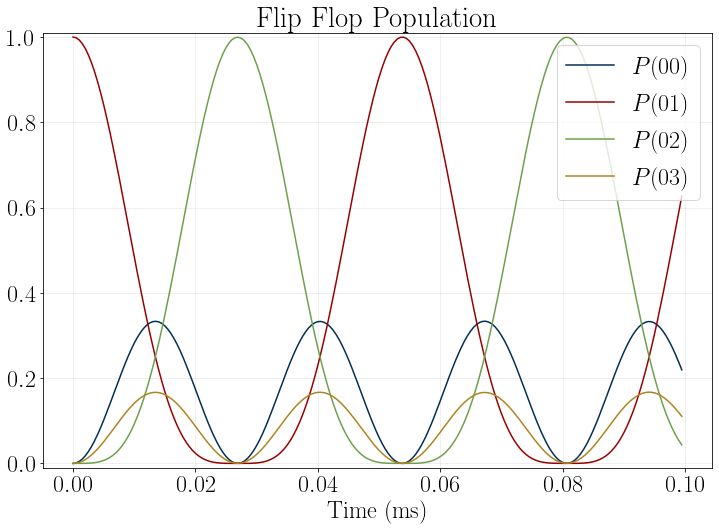

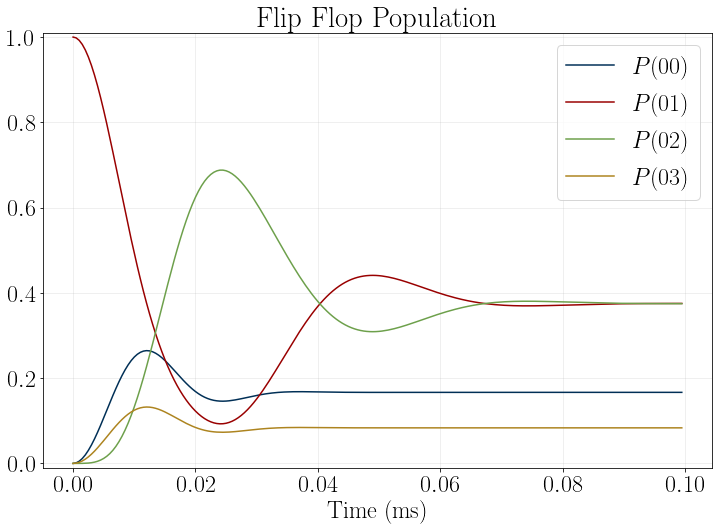

In [2]:
# You can play around with these
Np = 4 # Maximum number of photons per mode
#                    IX, IZ, XI, XX, XZ, YY, ZI, ZX, ZZ
approxInteraction = [ 0,  0,  1,  0,  0,  0,  0,  1,  0]
approxNoise =       [ 0,  0,  0,  1,  0,  1,  0,  0,  0]

detuning = 0
g = 0.001
T_Max = 100000
N_t =200
# Build parameter dicts
parameters_qubits = [
    {'Vt':11.4, 'wB':11.15, 'eps':1.15},
    {'Vt':11.4, 'wB':11.15, 'eps':1.15}
]
parameters_cavity = [
    {'wcav': 10 , 'g':g}
]
parameters_noise = [
    {'type':Pink(wl=2.0*np.pi*1e-15,wh=2.0*np.pi*1e3),'wn':0.323,'effected_donors':[1,0]},
    {'type':Pink(wl=2.0*np.pi*1e-15,wh=2.0*np.pi*1e3),'wn':0.323,'effected_donors':[0,1]}
]

system = FlipFlopSystem({
            'Nm': 1,
            'Np': Np,
            'Nd': 2,
            'Nn': 2,
            'parameters_cavity': parameters_cavity,
            'parameters_qubits': parameters_qubits,
            'parameters_noise': parameters_noise
        })
flipflopenergies = np.diag(system.getQubitHamiltonian())
w01 = flipflopenergies[1]-flipflopenergies[0]

# print(parameters_cavity[0])
system.parameters_cavity[0]['wcav']=w01-detuning
# print(parameters_cavity[0])
H0 = system.getSystemHamiltonian()
Hn = system.getNoiseHamiltonian()
# # Initialize cavity( to va)cuum state
# initial_cavity_state = np.zeros(((Np+1),1))
# initial_cavity_state[1,:] = 1
# # Initialize flip-flop to be |0...0>|1>
# initial_flipflop_state = np.zeros((16,1))
# initial_flipflop_state[1,:] = 1
# initial_total_state = np.kron(initial_cavity_state,initial_flipflop_state)

# t, rho, rho_zeroNoise =  computeDensityMatrix(system, initial_total_state, T_Max, N_t, dephaseOnly=True,approxInteraction=approxInteraction,approxNoise=approxNoise)
# rho_cav, rho_ff = partialTrace(rho_zeroNoise, 5, 16)
# timeString = datetime.datetime.now().strftime('%m%d%H%M%S')
# filename = plotFlipFlopPopulation(t, rho_ff, 2, states=[0,1,4,5],name = f"{timeString}_{2}q{4}p_FlipFlop_zeroNoise")
# # saveParameters(filename,parameters_qubits,parameters_cavity, parameters_noise,detuning=detuning,approxInteraction=approxInteraction,approxNoise=approxNoise)
# rho_cav, rho_ff = partialTrace(rho, 5, 16)
# timeString = datetime.datetime.now().strftime('%m%d%H%M%S')
# filename = plotFlipFlopPopulation(t, rho_ff, 2, states=[0,1,4,5],name = f"{timeString}_{2}q{4}p_FlipFlop_withNoise")
# # saveParameters(filename,parameters_qubits,parameters_cavity, parameters_noise,detuning=detuning,approxInteraction=approxInteraction,approxNoise=approxNoise)

system2 = FlipFlopSWSystem({
            'n0': 2,
            'parameters_cavity': parameters_cavity[0],
            'parameters_qubits': parameters_qubits,
            'parameters_noise': parameters_noise
        })
# print(system2.getSystemHamiltonian())
# print(parameters_cavity[0])
system2.parameters_cavity['wcav']=w01-detuning
# print(parameters_cavity[0])

H0sw = system2.getSystemHamiltonian()
Hnsw, _ = system2.getNoiseHamiltonian()
print(H0sw)
print(Hnsw[0])
print(Hnsw[1])
# Initialize state
initial_total_state = np.zeros((4,1))
initial_total_state[1,:] = 1


t, rho, rho_zeroNoise =  computeDensityMatrix(system2, initial_total_state, T_Max, N_t, dephaseOnly=True)
timeString = datetime.datetime.now().strftime('%m%d%H%M%S')
filename = plotFlipFlopPopulation(t, rho_zeroNoise, 2,name = f"{timeString}_{2}q{4}p_FlipFlop_zeroNoise")
# saveParameters(filename,parameters_qubits,parameters_cavity, parameters_noise,detuning=detuning)
timeString = datetime.datetime.now().strftime('%m%d%H%M%S')
filename = plotFlipFlopPopulation(t, rho, 2,name = f"{timeString}_{2}q{4}p_FlipFlop_withNoise")
# saveParameters(filename,parameters_qubits,parameters_cavity, parameters_noise,detuning=detuning)